# Desarrollo de punta a punta de un ScoreCard de originación


La implementación de Scorecards en la industria financiera lleva bastante tiempo en uso y aún es vigente, pues a pesar de la existencia y posibilidad de implementar clasificadores más complejos como *Random Forest, SVM, AdaBoost, Gradient Boosting, XGboost o incluso Redes Neuronales*, no son de fácil interpretación (cajas negras), sobre todo para las áreas comerciales, además de que sulen consumir mucho más recursos computacionales sin importar si el modelo está implementado en nube (la facturación será más costosa).
* **Ventas de la Scorecard**:
    * Mayor intrpretabilidad.
    * Facilidad de implementación y menor gasto computacional.
    * Los cambios que se requieran en producción 
   
* **Desventajas**:
    * En algunos casos menor precisión que los algoritmos arriba mencionados.

*******

<img src="option2.png" width="700" height="1500">

La escorecard desarrolada en el presente trabajo es para un **score de originación** para prestamos hipótecarios, cuya fuente de información usada se encuentra en: https://www.kaggle.com/competitions/home-credit-default-risk/data.

Se considera información interna de:
* Solicitudes
* Solcitudes previas
* Comportamiento de pagos

Información externa de:

* Buró de Crédito
* Comportamiento de pagos en otras insitituciones

El diagrama de como se relacionan los conjuntos de datos es el siguiente:


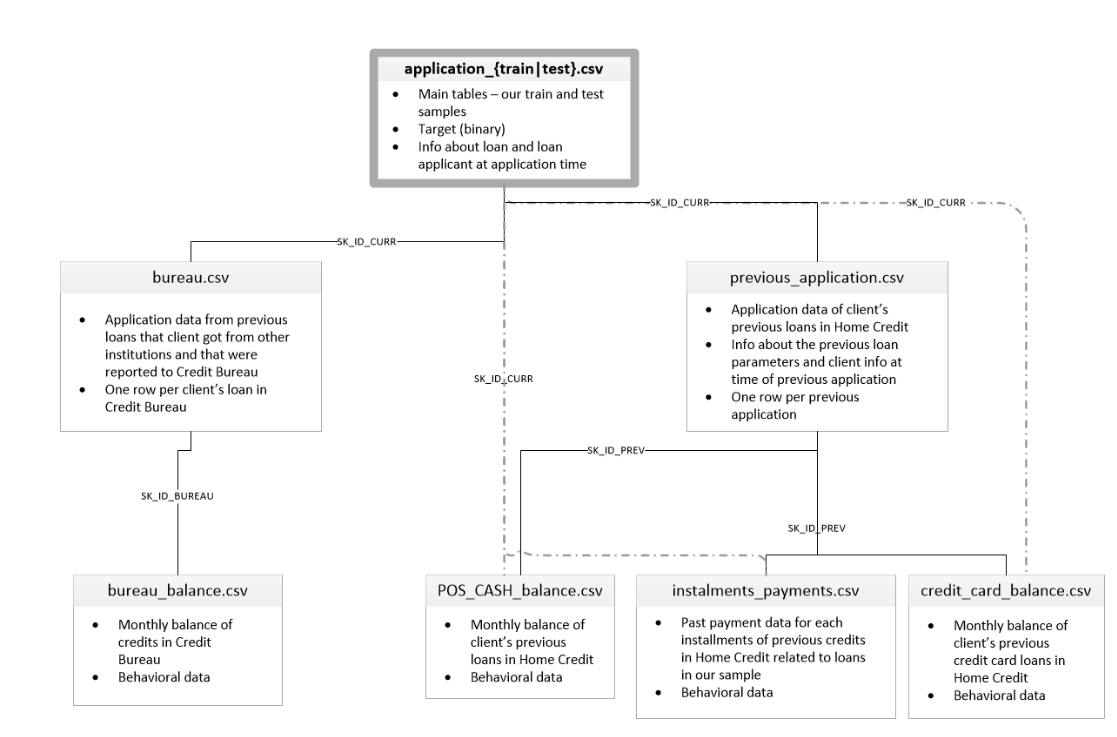
****

Algunos puntos a resaltar en el desarrollo son:

* El conjunto de datos después de realizar ingeniería de características y cruces,  cuenta con **220 columnas** y 3 millones de registros, lo cual conlleva a tener el problema de dimensionalidad.
    * Solución: Se aplican filtros de valores faltantes, correlación, **regularización $L1$** y Valor de la información (IV). **El resultado de aplicar estas técnicas es la selección del top 10 de características con más poder predictivo para el modelo.** 




* Se tiene un desbalance en la distribución del target (8% Ctes buenos vs 92% ctes malos).
    * Solución: Se aplican dos técnicas de remuestreo, SMOTE (*Synthetic Minority Oversampling Technique*) y Undersampleing, ambas combinanadas en un pipeline.
    
    

* En el conjunto de datos ya está definida la target y por tanto, la definición de cliente bueno y malo. Sin embargo, hay que tener en cuenta que se debe definir **mediante matrices de transición** y en conjunto con los **stakeholders**.

Cabe mencionar que la metodología seguida también es aplicable a la construcción de scores de comportamiento, cobranza, propensión, fraudes, satisfacción, retención, etc. 

# Módulos necesarios

In [ ]:
# Módulos base:

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/PERSONAL AGJM/PROYECTOS ML Y ESTAD./SCORE CARD/Home Credit Default Risk/HCDR end to end')

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 200


import numpy as np
import math
from collections import Counter
import pickle
import warnings
warnings.filterwarnings("ignore")

# Módulos para gráficos:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Módulos para remuestreo:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

# Módulos de Machine Learning:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve,recall_score,accuracy_score,precision_score,f1_score,cohen_kappa_score
from sklearn.impute import SimpleImputer

# Módulos Validación cruzada:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Módulos costomizados
#from Class_scoring import final_pipeline
from Class_scoring2 import final_pipeline # For test
from Clean_and_pp2 import completitud,imput_values_prev,imput_values,cal_IV,cal_WOE,cal_woe_in_validation,plot_feature_importance,get_feat_imp,plot_metrics,grid_search,var_to_rank,plot_dist_mora,score_distribution,plot_KS,table_BR


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Carga y limpieza de la información

In [ ]:
df=pd.read_pickle("Data/df.pkl")
print("<"*30,"El Dataframe contiene:",df.shape[0],"filas y",df.shape[1],"columnas.",">"*30)
df.head(3)

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< El Dataframe contiene: 307511 filas y 200 columnas. >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,pre_app_RATIO_AMT_APP_max,pre_app_RATIO_AMT_APP_min,pre_app_DAYS_DECISION_max,pre_app_DAYS_DECISION_min,pre_app_DAYS_DECISION_mean,pre_app_APP_APPROVED_sum,pre_app_APP_REFUSED_sum,pre_app_APP_CANCELED_sum,pre_app_APP_UNSED_OFFER_sum,pre_app_POS_PORT_sum,pre_app_CASH_PORT_sum,pre_app_CARD_PORT_sum,pre_app_CAR_PORT_sum,pre_app_OTHER_PORT_sum,pre_app_X_SELL_sum,pos_cash_SK_DPD_max,pos_cash_SK_DPD_mean,cc_AMT_BALANCE_mean,cc_AMT_CREDIT_LIMIT_ACTUAL_max,cc_AMT_CREDIT_LIMIT_ACTUAL_mean,cc_AMT_DRAWINGS_ATM_CURRENT_mean,cc_AMT_DRAWINGS_CURRENT_mean,cc_AMT_DRAWINGS_CURRENT_max,cc_CNT_DRAWINGS_ATM_CURRENT_mean,cc_CNT_DRAWINGS_ATM_CURRENT_max,cc_CNT_DRAWINGS_CURRENT_mean,cc_CNT_DRAWINGS_CURRENT_max,cc_CNT_INSTALMENT_MATURE_CUM_mean,cc_CARDS_ACTIVE_sum,cc_CARDS_COMPLETED_sum,cc_CARDS_REFUSED_sum,cc_CARDS_APROVED_sum,cc_CARDS_DEMAND_sum,cc_SK_DPD_max,cc_SK_DPD_mean,ip_DAYS_INSTALMENT_max,ip_DAYS_INSTALMENT_min,ip_DAYS_INSTALMENT_mean,ip_DAYS_ENTRY_PAYMENT_max,ip_DAYS_ENTRY_PAYMENT_min,ip_DAYS_ENTRY_PAYMENT_mean,ip_AMT_INSTALMENT_max,ip_AMT_INSTALMENT_min,ip_AMT_INSTALMENT_mean,ip_AMT_PAYMENT_max,ip_AMT_PAYMENT_min,ip_AMT_PAYMENT_mean,bd_CREDITS_ACTIVE_sum,bd_CREDITS_CLOSED_sum,bd_CONSUMER_CREDITS_sum,bd_CREDITS_CARDS_sum,bd_CAR_LOANS_sum,bd_MICRO_LOANS_sum,bd_DAYS_CREDIT_mean,bd_DAYS_CREDIT_max,bd_DAYS_CREDIT_min,bd_CREDIT_DAY_OVERDUE_max,bd_CREDIT_DAY_OVERDUE_mean,bd_DAYS_CREDIT_ENDDATE_mean,bd_DAYS_CREDIT_ENDDATE_max,bd_DAYS_CREDIT_ENDDATE_min,bd_CNT_CREDIT_PROLONG_sum,bd_CNT_CREDIT_PROLONG_mean,bd_AMT_CREDIT_SUM_mean,bd_AMT_CREDIT_SUM_max,bd_AMT_CREDIT_SUM_DEBT_mean,bd_AMT_CREDIT_SUM_DEBT_max,bd_AMT_CREDIT_SUM_LIMIT_sum,bd_AMT_CREDIT_SUM_LIMIT_mean,bd_AMT_CREDIT_SUM_LIMIT_max,bd_AMT_CREDIT_SUM_OVERDUE_max,bd_AMT_CREDIT_SUM_OVERDUE_mean,bd_DAYS_CREDIT_UPDATE_max,bd_DAYS_CREDIT_U

In [ ]:
#Validamos registros nulos por columna:
completitud(df).head(3)

,Columna,Total_reg_nulos,Per_completitud
142,cc_AMT_DRAWINGS_ATM_CURRENT_mean,246371,19.882216
145,cc_CNT_DRAWINGS_ATM_CURRENT_mean,246371,19.882216
146,cc_CNT_DRAWINGS_ATM_CURRENT_max,246371,19.882216


In [ ]:
# Al aplicar esta función se imputa el valor -1 sobre variables de Buró que tienen valores faltantes,
# debido a que existen clientes sin información.
imput_values_prev(df)

In [ ]:
# Validamos los registros nulos por variable
c=completitud(df)
c.head(5)

,Columna,Total_reg_nulos,Per_completitud
142,cc_AMT_DRAWINGS_ATM_CURRENT_mean,246371,19.882216
145,cc_CNT_DRAWINGS_ATM_CURRENT_mean,246371,19.882216
146,cc_CNT_DRAWINGS_ATM_CURRENT_max,246371,19.882216
141,cc_AMT_CREDIT_LIMIT_ACTUAL_mean,220606,28.260778
139,cc_AMT_BALANCE_mean,220606,28.260778


## Filtro por valores nulos:

In [ ]:
# El umbral elegido para eliminar columnas con valores nulos es del 15%:
var_nulls=c[c["Per_completitud"]<85]["Columna"].to_list()
print(len(var_nulls),'variables a eliminar')
df.drop(columns=var_nulls,inplace=True)

70 variables a eliminar


In [ ]:
# Las columnas de entrega de documentos (#FLAG_DOCUMENT_n) las podemos resumir en dos:
# Total de documentos entregados y % de docs. entregados.
flag_documents=[x for x in df.columns if x.startswith("FLAG_DOCUMENT_")]
df["SUM_FLAGS_DOCUMENTS"]=0
for var in flag_documents:
    df["SUM_FLAGS_DOCUMENTS"]+=df[var]

df["PERC_DOCUMENTS"]=df["SUM_FLAGS_DOCUMENTS"]/20
df.drop(columns=flag_documents,inplace=True)

## Clasificación de variables:

In [ ]:
# Lista con las variables categóricas:
feat_cat=list(set(df.select_dtypes(exclude=["number"]).columns.to_list()+[c for c in df.columns if c.startswith("FLAG_")]))
# Lista con las variables numéricas:
feat_num=[c for c in df.columns if c not in feat_cat+["SK_ID_CURR","TARGET"]]

## Filtro por correlación de Pearson:

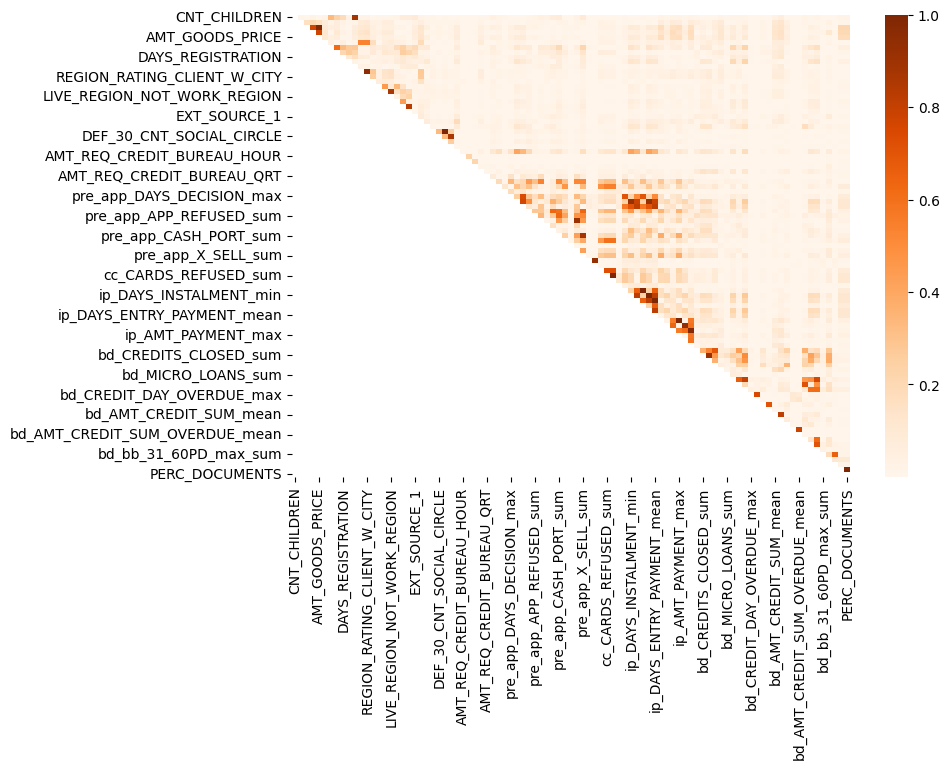

In [ ]:
mat_corr=df[feat_num].corr().abs()
upper = mat_corr.where(np.triu(np.ones(mat_corr.shape), k=1).astype(np.bool))
sns.heatmap(upper,cmap='Oranges')
fig=plt.gcf()
fig.set_size_inches(9,6)
plt.show()

In [ ]:
# Filtro de correlación de Pearson con un treshold de 0.85.
feats_to_drop_corr= [c for c in upper.columns if any(upper[c] > 0.85)]
df.drop(columns=feats_to_drop_corr,inplace=True)

In [ ]:
#Acualizamos lista de variables:
feat_num=[c for c in df.columns if c not in feat_cat+["SK_ID_CURR","TARGET"]]

## Filtro por Umbral de Varianza

In [ ]:
# Treshold elegido de 0.01.
from sklearn.feature_selection import VarianceThreshold
v_t=VarianceThreshold(0.01)
v_t.fit(df[feat_num])
vars_vt=[x for x in df[feat_num].columns if x not in  df[feat_num].columns [v_t.get_support()]]
df.drop(columns=vars_vt,inplace=True)

#Acualizamos lista de variables:
feat_num=[c for c in df.columns if c not in feat_cat+["SK_ID_CURR","TARGET"]]

## Filtro por IV en variables categóricas
    Se aplican los siguientes criterios bien conocidos en la industria de acuerdo al valor del IV:
    *   Menos de 0.02	Nulo poder predictivo
    *   de 0.02 a 0.1	débil poder predictivo
    *   0.1 to 0.3 poder predictivo medio
    *   0.3 to 0.5 fuerte poder predictivo
    *   0.5	poder predictivo sospechoso

In [ ]:
lista=[]
for f in feat_cat:
      lista.append(cal_IV(df,f,'TARGET'))
IV=pd.concat(lista)
IV.sort_values(by="IV",ascending=False)

,Variable,IV
49,ORGANIZATION_TYPE,0.073368
2,NAME_INCOME_TYPE,0.058325
4,NAME_EDUCATION_TYPE,0.050836
1,CODE_GENDER,0.038597
1,FLAG_EMP_PHONE,0.032907
2,NAME_FAMILY_STATUS,0.021698
5,NAME_HOUSING_TYPE,0.015730
0,NAME_CONTRACT_TYPE,0.015039
0,FLAG_WORK_PHONE,0.010329
1,FLAG_PHONE,0.007942


In [ ]:
# De acuerdo a los criterios, se eliminan todas las variables categóricas por ser predictores débiles:
df.drop(columns=feat_cat,inplace=True)

# División del conjunto de datos en train y test

In [ ]:
X=df[[x for x in df.columns if x not in ["SK_ID_CURR","TARGET"]]]
y=df["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246008, 70), (61503, 70), (246008,), (61503,))

# Imputación valores faltantes

## Imputación en train:
Imputamos valores faltantes primero en train y los valores usados para dicha imputación se guardan para       usarlos en la imputación de test

In [ ]:
imput_train_values=imput_values(X_train)
#Guardamos los valores:
imput_train_values.to_pickle("\Data\imput_train_values.pkl")

In [ ]:
imput_train_values.head(5)

,variable,valor_imputado
0,bd_AMT_CREDIT_SUM_mean,-1.0
1,bd_AMT_CREDIT_SUM_max,-1.0
2,bd_bb_120PD_MORE_max_sum,-1.0
3,bd_MICRO_LOANS_sum,-1.0
4,bd_CAR_LOANS_sum,-1.0


## Imputación en *test*:

In [ ]:
#Convertirmos a diccionario los valores a imputar en test:
imput_dict_values=imput_train_values.to_dict('split')
imput_dict_values=dict(imput_dict_values["data"])
for k, v in imput_dict_values.items():  # Convertimos a float
    imput_dict_values[k] = float(v)

In [ ]:
#Imputamos en test:
X_test=X_test.fillna(value=imput_dict_values)
X_test["DAYS_LAST_PHONE_CHANGE"]=X_test["DAYS_LAST_PHONE_CHANGE"].fillna(X_test["DAYS_LAST_PHONE_CHANGE"].mean())

# Ajuste de regresión con penalización $l1$

In [ ]:
X_c=X.copy()
imput_values(X_c)
reg_pen=LogisticRegression(C=0.05, penalty='l1',solver='liblinear',class_weight="balanced")
reg_pen.fit(X_c, y)

LogisticRegression(C=0.05, class_weight='balanced', penalty='l1',
                   solver='liblinear')

## Importancia de los predictores:

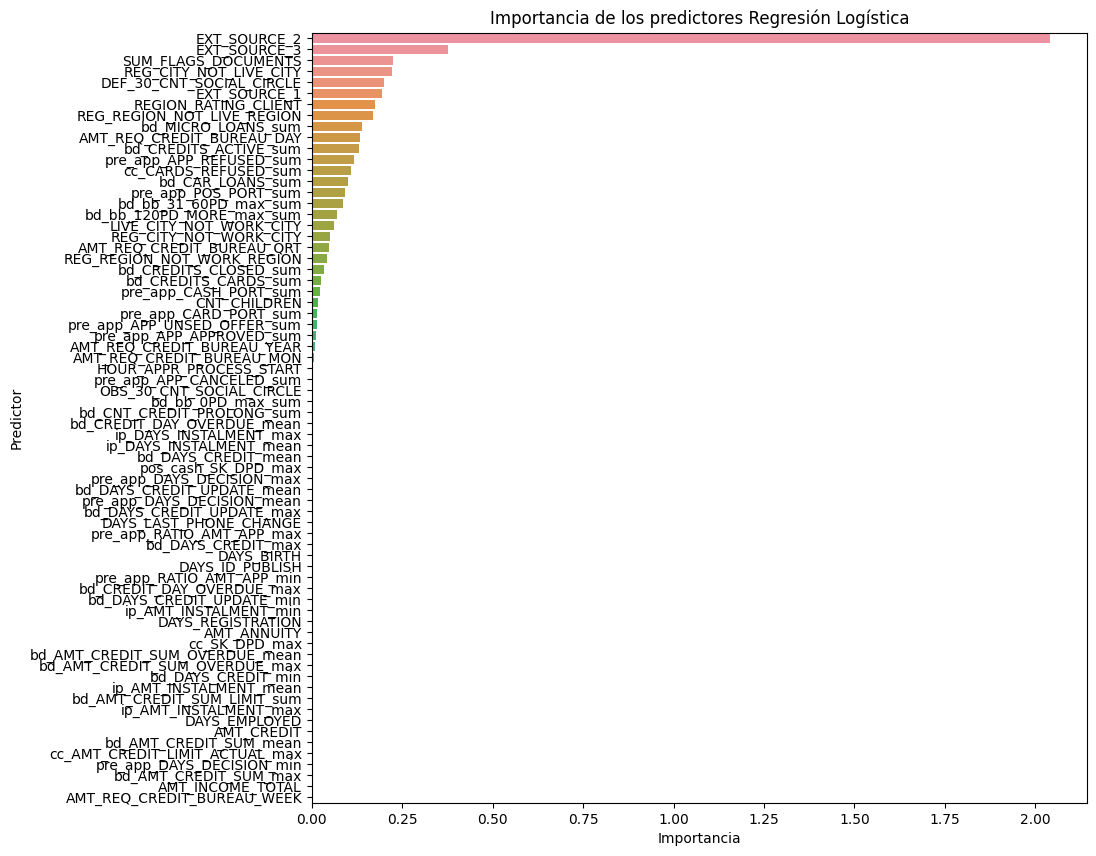

In [ ]:
plot_feature_importance(X_c,data_arg=False,model=reg_pen)

## Selección top 25 predictores más importantes:

In [ ]:
get_feat=get_feat_imp(reg_pen,False,25,X_c)
get_feat

,feature,importance
0,EXT_SOURCE_2,2.040274
1,EXT_SOURCE_3,0.376824
2,SUM_FLAGS_DOCUMENTS,0.225622
3,REG_CITY_NOT_LIVE_CITY,0.223002
4,DEF_30_CNT_SOCIAL_CIRCLE,0.200256
5,EXT_SOURCE_1,0.194324
6,REGION_RATING_CLIENT,0.176116
7,REG_REGION_NOT_LIVE_REGION,0.170190
8,bd_MICRO_LOANS_sum,0.137872
9,AMT_REQ_CREDIT_BUREAU_DAY,0.133776


In [ ]:
selected_features =get_feat["feature"].tolist()
selected_features

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'SUM_FLAGS_DOCUMENTS',
 'REG_CITY_NOT_LIVE_CITY',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_1',
 'REGION_RATING_CLIENT',
 'REG_REGION_NOT_LIVE_REGION',
 'bd_MICRO_LOANS_sum',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'bd_CREDITS_ACTIVE_sum',
 'pre_app_APP_REFUSED_sum',
 'cc_CARDS_REFUSED_sum',
 'bd_CAR_LOANS_sum',
 'pre_app_POS_PORT_sum',
 'bd_bb_31_60PD_max_sum',
 'bd_bb_120PD_MORE_max_sum',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'REG_REGION_NOT_WORK_REGION',
 'bd_CREDITS_CLOSED_sum',
 'bd_CREDITS_CARDS_sum',
 'pre_app_CASH_PORT_sum',
 'CNT_CHILDREN']

# Validación distribución predictores seleccionados

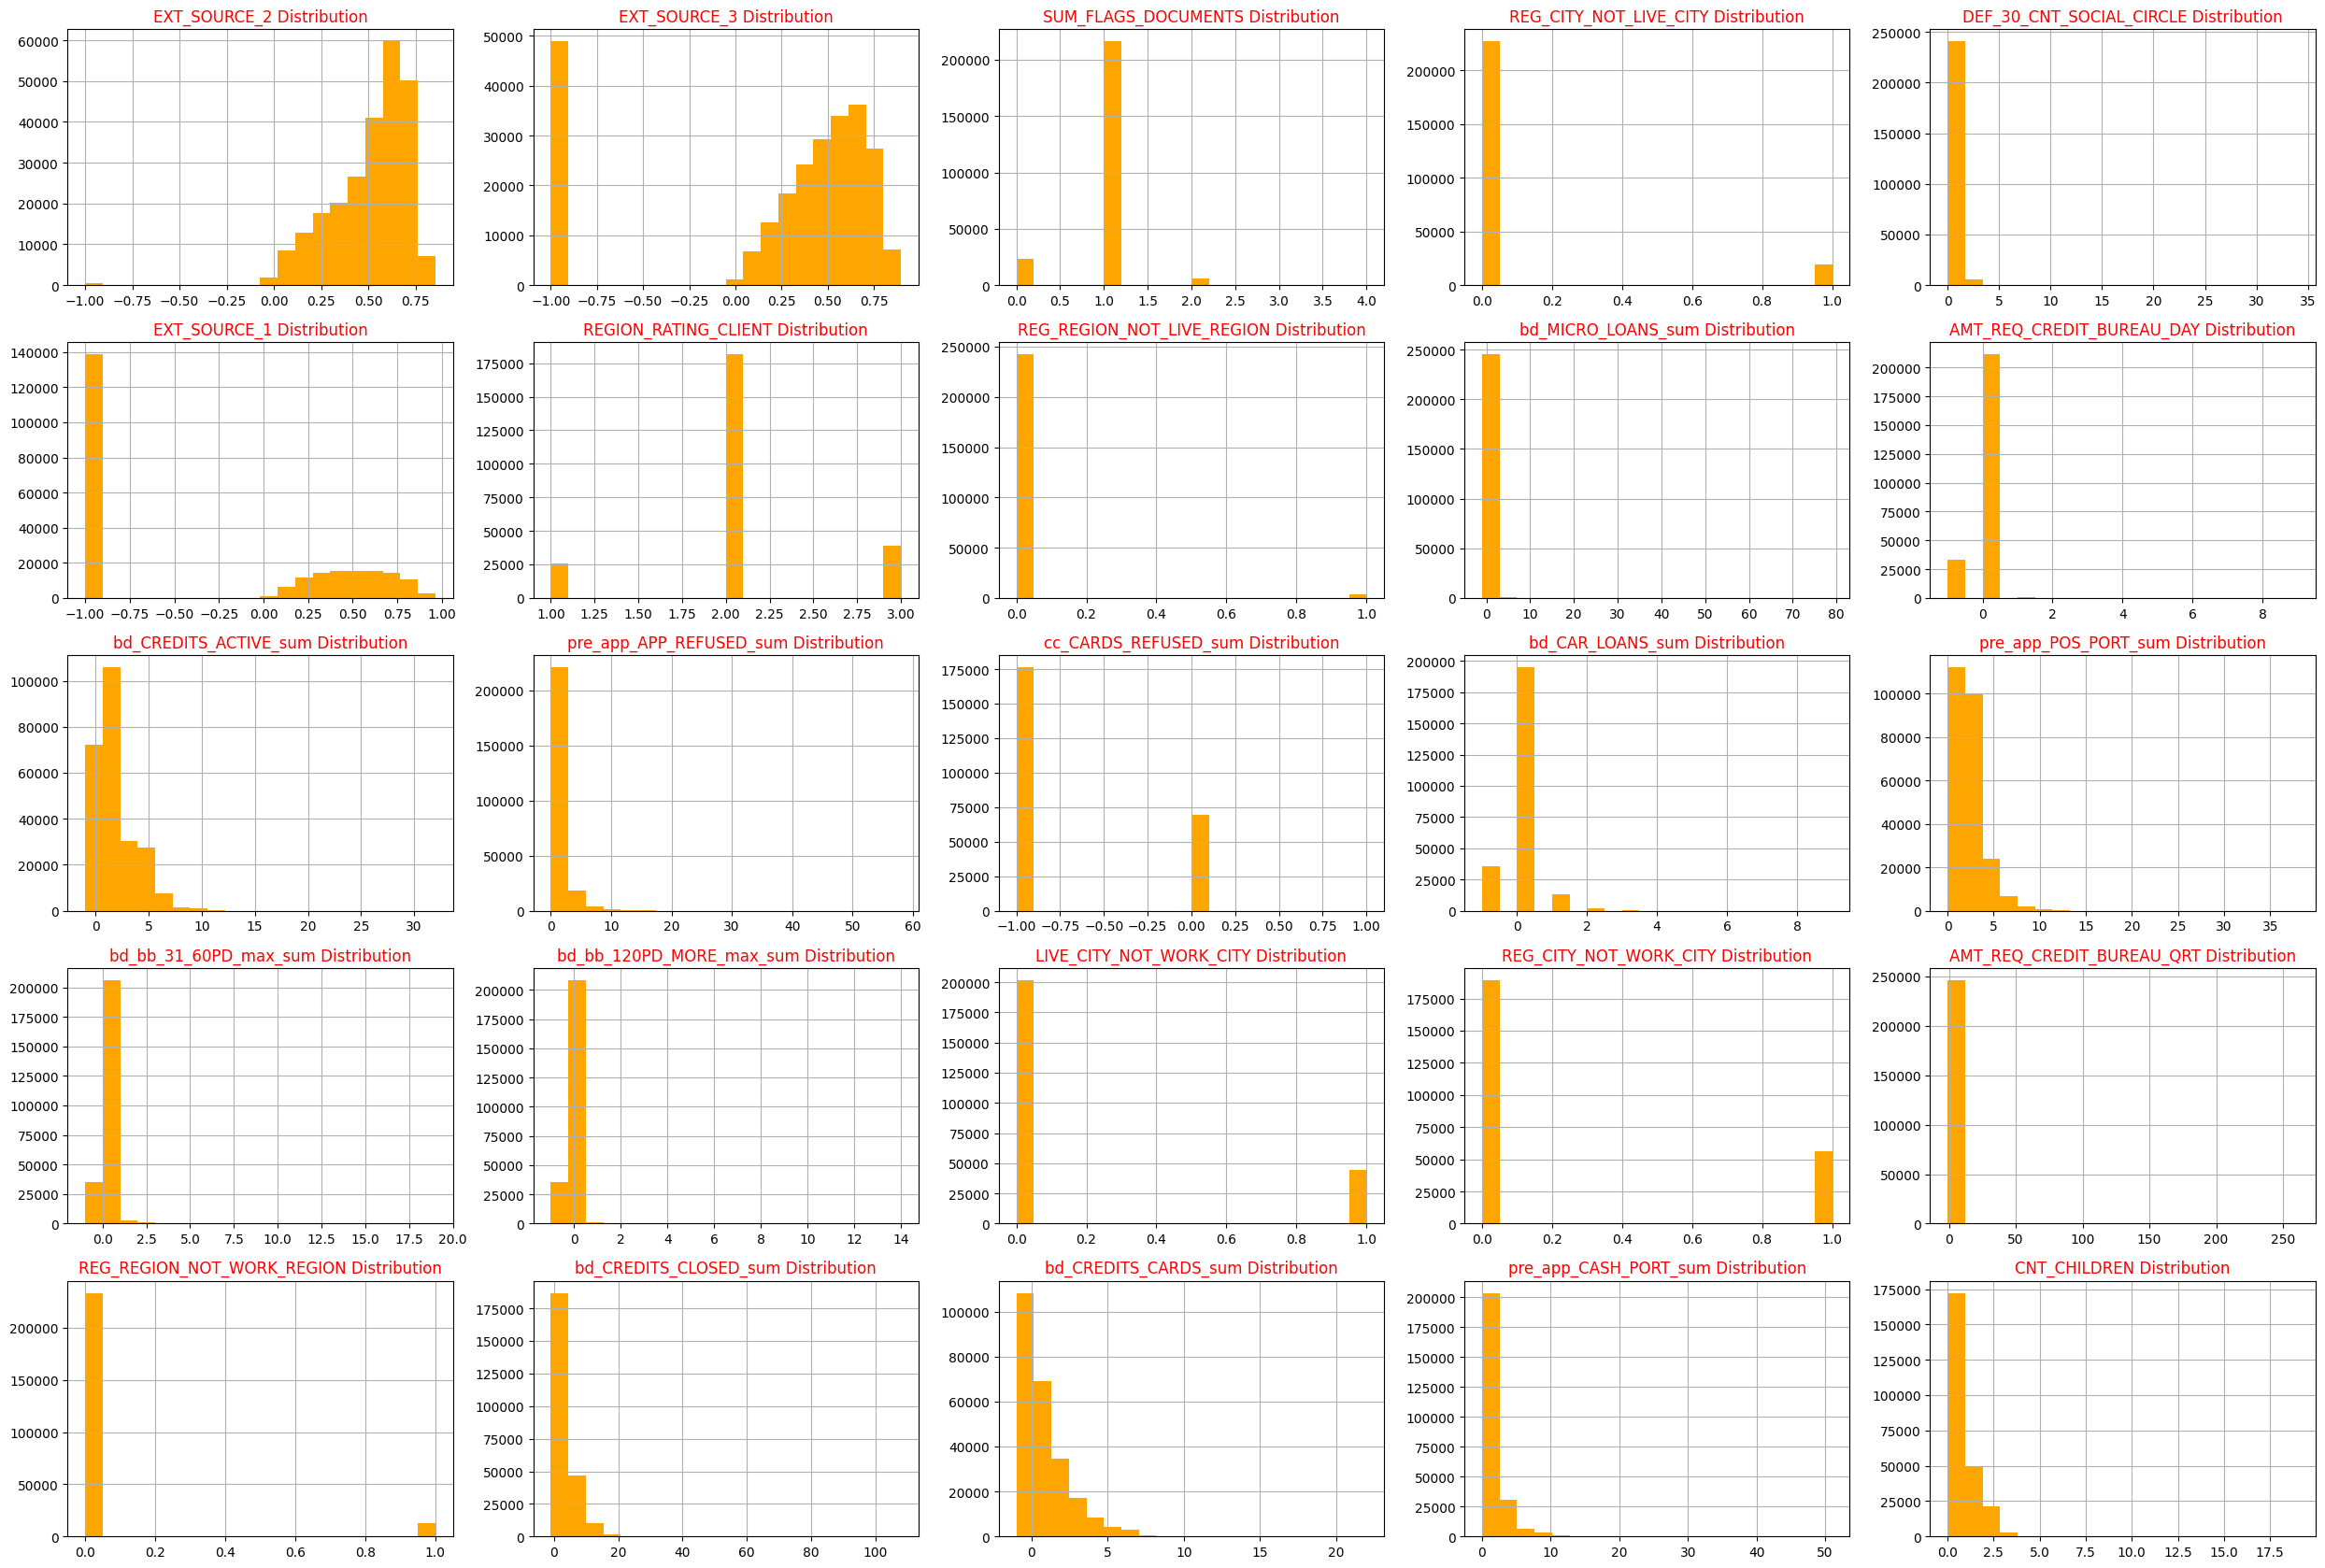

In [ ]:
fig=plt.figure(figsize=(25,20))
for i, feature in enumerate(X_train[selected_features].columns):
    ax=fig.add_subplot(6,5,i+1)
    X_train[feature].hist(bins=20,ax=ax,facecolor='orange')
    ax.set_title(feature+" Distribution",color='red')

fig.tight_layout()
plt.show()

# Rankeo de variables
Los límites de los rangos se definen manualmente ya que en un caso práctico, estos deben de acordarse en consenso con los stakeholders.
Las definiciones se encuentran dentro de la función correspondiente.

In [ ]:
# Ranqueamos las columnas selecciónadas:
var_to_rank(X_train)

In [ ]:
# Selecionamos las variables rankeadas:
feats_rank=[c for c in X_train.columns if c.endswith('_bin')]
feats_rank
print(len(feats_rank))

25


In [ ]:
# Unimos el conjunto de entrenamiento con el target (necesario para calcular el IV)
X_train=pd.merge(X_train,y_train,left_index=True, right_index=True)

# Cálculo de IV
El IV se calcula sobre el conjunto de entrenamiento con el objetivo de selecciónar a los mejores predictores en base al sigueinte criterio:

*   Menos de 0.02    Nulo poder predictivo
*   de 0.02 a 0.1    débil poder predictivo
*   0.1 to 0.3 poder predictivo medio
*   0.3 to 0.5 fuerte poder predictivo
*   0.5    poder predictivo sospechoso

In [ ]:
lista=[]
for f in feats_rank:
      lista.append(cal_IV(X_train,f,'TARGET'))
IV=pd.concat(lista)
IV.sort_values(by="IV",ascending=False)

,Variable,IV
4,EXT_SOURCE_3_bin,0.301210
4,EXT_SOURCE_2_bin,0.269254
2,EXT_SOURCE_1_bin,0.127046
1,REGION_RATING_CLIENT_bin,0.047741
2,bd_CREDITS_ACTIVE_sum_bin,0.047378
2,bd_CREDITS_CLOSED_sum_bin,0.038582
0,pre_app_APP_REFUSED_sum_bin,0.035701
0,REG_CITY_NOT_WORK_CITY_bin,0.032344
1,SUM_FLAGS_DOCUMENTS_bin,0.022805
0,REG_CITY_NOT_LIVE_CITY_bin,0.021715


In [ ]:
# Nos quedamos con las variables cuyo IV sea mayor a 0.02. Se recomienda tomar esta decisión en concenso con
# los stackholders.
var_f=IV[IV["IV"]>0.02].sort_values(by="IV",ascending=False).reset_index(drop=True)
var_f

,Variable,IV
0,EXT_SOURCE_3_bin,0.301210
1,EXT_SOURCE_2_bin,0.269254
2,EXT_SOURCE_1_bin,0.127046
3,REGION_RATING_CLIENT_bin,0.047741
4,bd_CREDITS_ACTIVE_sum_bin,0.047378
5,bd_CREDITS_CLOSED_sum_bin,0.038582
6,pre_app_APP_REFUSED_sum_bin,0.035701
7,REG_CITY_NOT_WORK_CITY_bin,0.032344
8,SUM_FLAGS_DOCUMENTS_bin,0.022805
9,REG_CITY_NOT_LIVE_CITY_bin,0.021715


# Creación lista 10 variables rankeadas finales

In [ ]:
#Lista con todas las variables finales cuyo IV>0.02
feats_final=var_f["Variable"].tolist()
print("Total de columnas a usar en la Scorecard:",len(feats_final))
print("-"*30)
feats_final

Total de columnas a usar en la Scorecard: 10
------------------------------


['EXT_SOURCE_3_bin',
 'EXT_SOURCE_2_bin',
 'EXT_SOURCE_1_bin',
 'REGION_RATING_CLIENT_bin',
 'bd_CREDITS_ACTIVE_sum_bin',
 'bd_CREDITS_CLOSED_sum_bin',
 'pre_app_APP_REFUSED_sum_bin',
 'REG_CITY_NOT_WORK_CITY_bin',
 'SUM_FLAGS_DOCUMENTS_bin',
 'REG_CITY_NOT_LIVE_CITY_bin']

## Validación rangos vs %Mora

<Figure size 640x480 with 0 Axes>

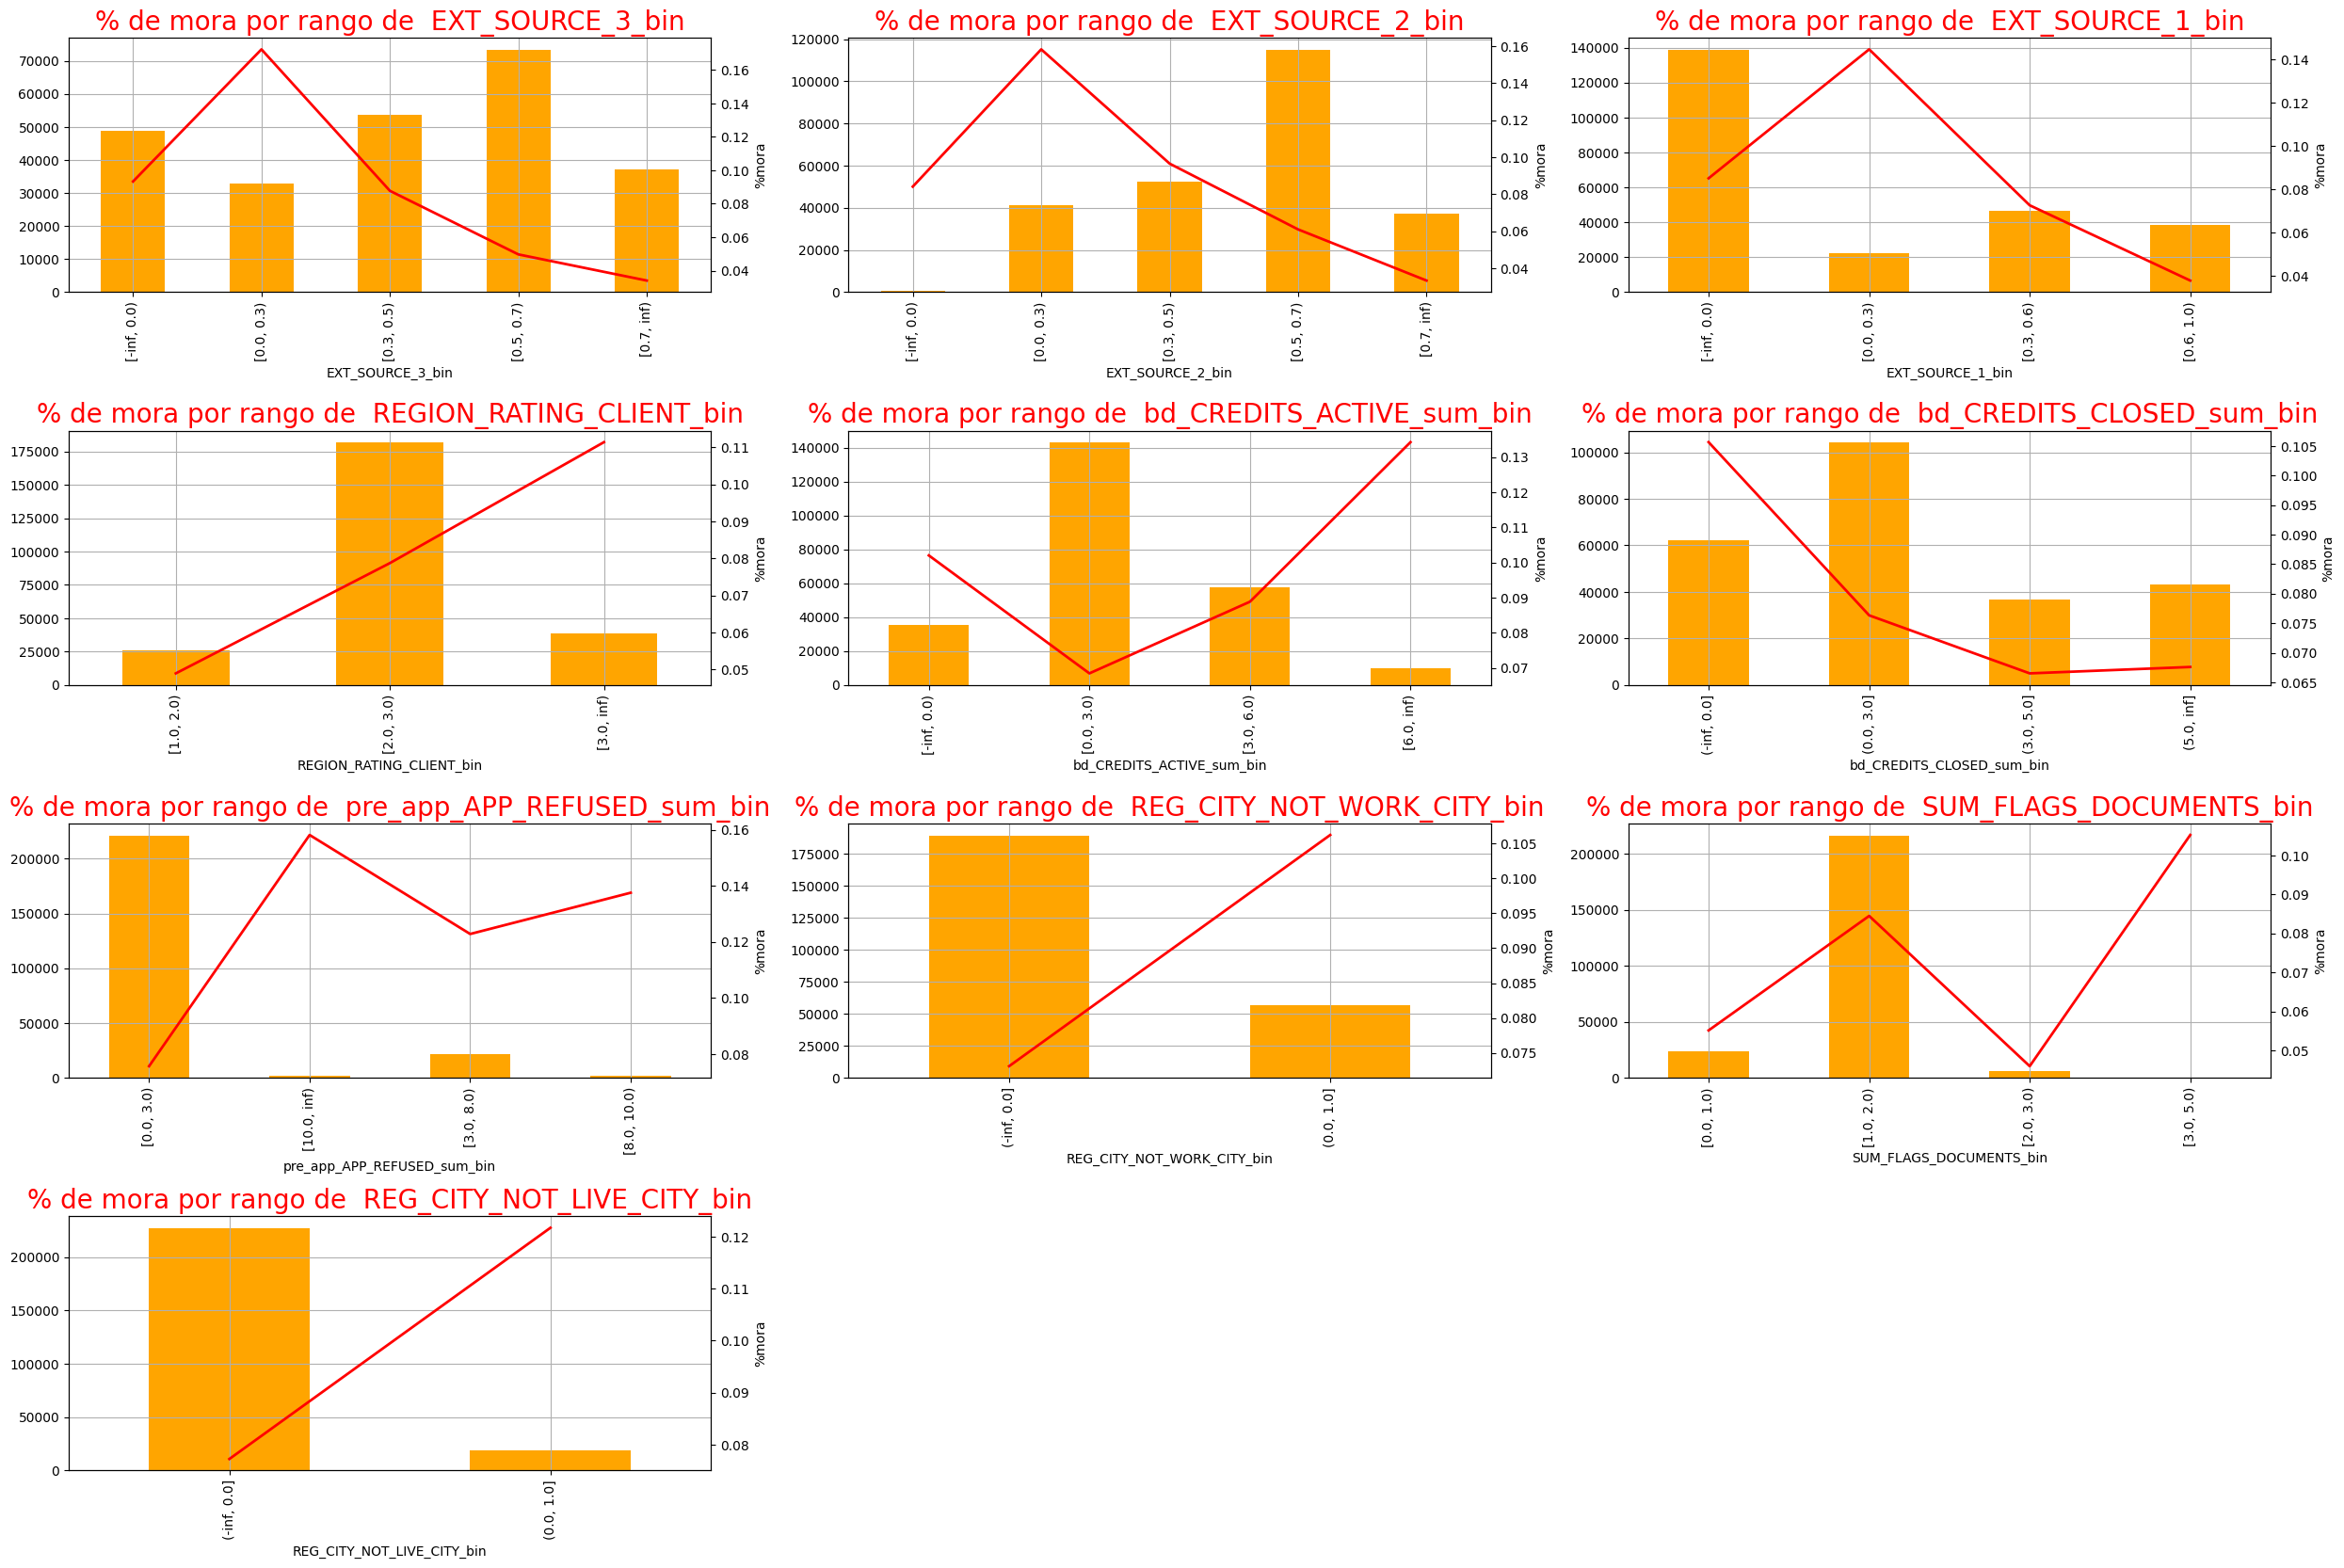

In [ ]:
plot_dist_mora(X_train,feats_final,"TARGET")

# Cálculo de WoE en *train*

In [ ]:
X_train_woe=cal_WOE(X_train,feats_final,'TARGET')

## Mapeo rangos a WoE

In [ ]:
feats_final_sr=[
 'EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1','REGION_RATING_CLIENT','bd_CREDITS_ACTIVE_sum',
 'bd_CREDITS_CLOSED_sum','pre_app_APP_REFUSED_sum','REG_CITY_NOT_WORK_CITY','SUM_FLAGS_DOCUMENTS',
 'REG_CITY_NOT_LIVE_CITY']

In [ ]:
df_bin_to_woe = pd.DataFrame(columns = ['features','bin','woe'])
for f in feats_final_sr:
    b = f+'_bin'
    w = 'woe_'+f+'_bin'
    X_train_woe_ = X_train_woe[[w,b]].drop_duplicates()
    X_train_woe_.columns = ['woe','bin']
    X_train_woe_['features'] = f
    X_train_woe_=X_train_woe_[['features','bin','woe']]
    df_bin_to_woe = pd.concat([df_bin_to_woe,X_train_woe_])
df_bin_to_woe.reset_index(drop=True)

,features,bin,woe
0,EXT_SOURCE_3,"[0.0, 0.3)",0.863822
1,EXT_SOURCE_3,"[0.5, 0.7)",-0.518292
2,EXT_SOURCE_3,"[0.3, 0.5)",0.091063
3,EXT_SOURCE_3,"[0.7, inf)",-0.913082
4,EXT_SOURCE_3,"[-inf, 0.0)",0.158746
5,EXT_SOURCE_2,"[0.5, 0.7)",-0.301000
6,EXT_SOURCE_2,"[0.0, 0.3)",0.761337
7,EXT_SOURCE_2,"[0.7, inf)",-0.932949
8,EXT_SOURCE_2,"[0.3, 0.5)",0.196294
9,EXT_SOURCE_2,"[-inf, 0.0)",0.044971


In [ ]:
df_bin_to_woe.to_pickle("map_feat_bin_woe.pkl")

# Cálculo WoE en Test
Un punto importante a tomar en cuenta es que se deben usar los valores de WoE calculado en *Train* e imputarlos en *Test* , pues de otra forma, el modelo se estaría testeando con información conocida.

In [ ]:
# Calculamos los rangos e imputamos WoE sobre test:
var_to_rank(X_test)
X_test=pd.merge(X_test,y_test,left_index=True, right_index=True)
cal_woe_in_validation(df_woe=df_bin_to_woe,df_test=X_test,cols=feats_final_sr)

# Ajuste Reg. Log. con WoE

In [ ]:
feats_woe=[f for f in X_train_woe.columns if f.startswith("woe")]

In [ ]:
y_train.value_counts(1)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

Dado que tenemos una **distribución desbalanceada de la TARGET (92% vs 8%), usaremos remuestreo** de la siguiente forma:


1.   Aplicamos un muestreo SMOTE, después
2.   Aplicamos un undersampling, finalmente
3.   Ajuste del modelo.



In [ ]:
steps=[
['smote', SMOTE(random_state=11,sampling_strategy=0.2)],
['under', RandomUnderSampler(sampling_strategy=0.4)],
['model', LogisticRegression(random_state=10,max_iter=1000)]
      ]
pipeline = imbpipeline(steps= steps)
hiper_params={'model__solver':["liblinear",'lbfgs','newton-cholesky','saga']}

In [ ]:
best_model=grid_search(X_train_woe[feats_woe],y_train,pipeline, hiper_params)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Score : 0.8775893276200353
Best Params : {'model__solver': 'liblinear'}


In [ ]:
#Score en train:
y_train_pred_sco_bm=best_model.predict_proba(X_train_woe[feats_woe])[:,1]
#Score en test:
y_test_pred_sco_bm=best_model.predict_proba(X_test[feats_woe])[:,1]
#Score en train:
y_train_pred_bm=best_model.predict(X_train_woe[feats_woe])
#Score en test:
y_test_pred_bm=best_model.predict(X_test[feats_woe])

## Desempeño en train:

---------------------------------------------------------------------------------------------------------------------------------------
MÉTRICAS DE DESEMPEÑO DEL CLASIFICADOR:
---------------------------------------------------------------------------------------------------------------------------------------
PRECISION=0.243
ACCURACY=0.877
RECALL=0.244
F1 SCORE=0.244
ROC AUC=0.721
GINI=0.442
KAPPA SCORE=0.177


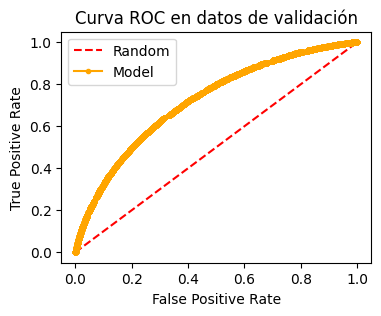

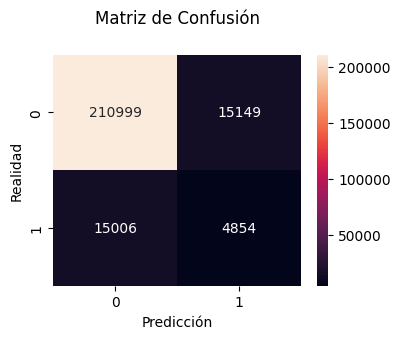

In [ ]:
plot_metrics(y_train,y_train_pred_bm,y_train_pred_sco_bm)

## Desempeño en Test:

---------------------------------------------------------------------------------------------------------------------------------------
MÉTRICAS DE DESEMPEÑO DEL CLASIFICADOR:
---------------------------------------------------------------------------------------------------------------------------------------
PRECISION=0.245
ACCURACY=0.878
RECALL=0.246
F1 SCORE=0.246
ROC AUC=0.729
GINI=0.457
KAPPA SCORE=0.179


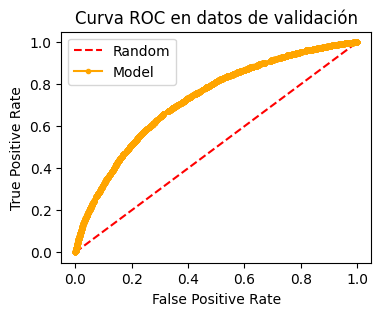

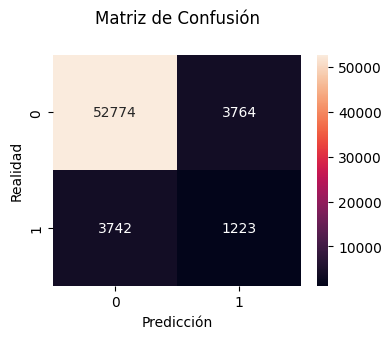

In [ ]:
plot_metrics(y_test,y_test_pred_bm,y_test_pred_sco_bm)

## Guardado de insumos utilizados

In [ ]:
filename = 'HCDR_model.pkl'
pickle.dump(best_model, open(filename,'wb'))

filename2='predictors.pkl'
pickle.dump(feats_woe, open(filename2,'wb'))

In [ ]:
filename='HCDR_model.pkl'
md=pickle.load(open(filename,'rb'))

# Contrucción de la ScoreCard

In [ ]:
# Pipeline de ajustado
best_model

Pipeline(steps=[('smote', SMOTE(random_state=11, sampling_strategy=0.2)),
                ('under', RandomUnderSampler(sampling_strategy=0.4)),
                ['model',
                 LogisticRegression(max_iter=1000, random_state=10,
                                    solver='liblinear')]])

## ScoreCard:

In [ ]:
sc=final_pipeline()
B=50
ScoreCard=sc.generate_scorecard(best_model.named_steps["model"].coef_,df_bin_to_woe,feats_final_sr,B)
ScoreCard

,Variable,Binning,Score
0,EXT_SOURCE_3,"[0.0, 0.3)",-37
1,EXT_SOURCE_3,"[0.5, 0.7)",22
2,EXT_SOURCE_3,"[0.3, 0.5)",-4
3,EXT_SOURCE_3,"[0.7, inf)",39
4,EXT_SOURCE_3,"[-inf, 0.0)",-7
5,EXT_SOURCE_2,"[0.5, 0.7)",12
6,EXT_SOURCE_2,"[0.0, 0.3)",-31
7,EXT_SOURCE_2,"[0.7, inf)",38
8,EXT_SOURCE_2,"[0.3, 0.5)",-8
9,EXT_SOURCE_2,"[-inf, 0.0)",-2


In [ ]:
ScoreCard.to_pickle("ScoreCard.pkl")

# Validaciones Scores:

## Cálculo del score en Test:

In [ ]:
A = 650 #Puntos base
test_score=sc.calculate_score_with_card(X_test[feats_final_sr],ScoreCard,A)

In [ ]:
test_score=pd.merge(test_score,y_test,left_index=True,right_index=True)

In [ ]:
test_score.to_pickle("score_in_test.pkl")

## Cálculo del score en Train

In [ ]:
train_score=sc.calculate_score_with_card(X_train[feats_final_sr],ScoreCard,A)

In [ ]:
train_score=pd.merge(train_score,y_train,left_index=True,right_index=True)

In [ ]:
train_score.to_pickle("score_in_train.pkl")

In [ ]:
#Lectura de pickles:
#test_score=pd.read_pickle("score_in_test.pkl")
#train_score=pd.read_pickle("score_in_train.pkl")

## Distribución del Score en train y test:

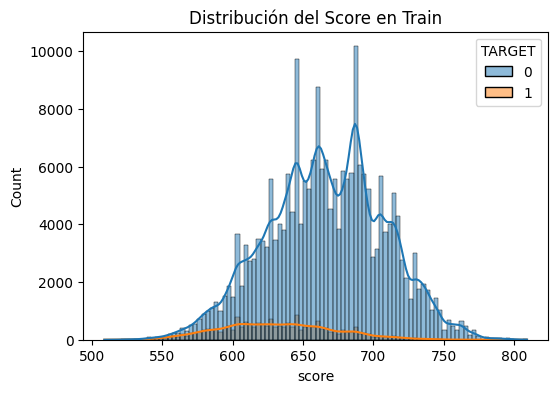

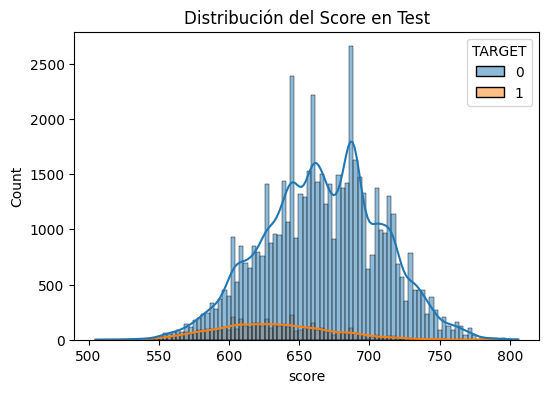

In [ ]:
score_distribution(train_score,"score","TARGET",100,"Distribución del Score en Train"),
score_distribution(test_score,"score","TARGET",100,"Distribución del Score en Test")

# Cálculo del estadístico KS en train y test:

El estadístico KS en <<<Train>>> es: 0.32454383400609194
El estadístico KS en <<<Test>>> es: 0.3459258960019297


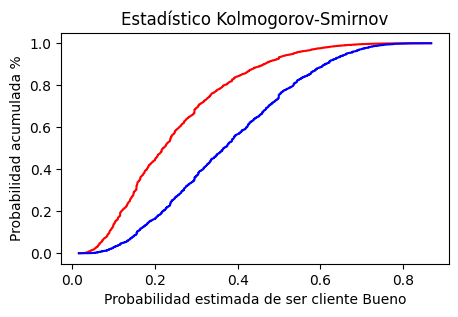

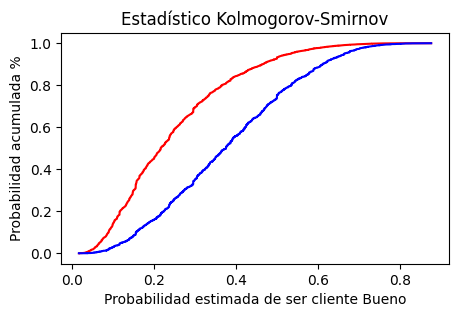

In [ ]:
plot_KS(X_train_woe,"<<<Train>>>","TARGET",feats_woe,best_model),
plot_KS(X_test,"<<<Test>>>","TARGET",feats_woe,best_model)

# Tabla de Bad Rate por rangos de Score

In [ ]:
bins_score=[506,608,628,643,655,666,679,689,703,720]
table_BR(test_score,bins_score,False,"score","TARGET")

,Rank_score,REGION_RATING_CLIENT,TARGET,BAD_RATE
0,"[506, 608)",6298,1438,0.228326
1,"[608, 628)",6323,947,0.149771
2,"[628, 643)",6378,695,0.108968
3,"[643, 655)",6235,483,0.077466
4,"[655, 666)",6267,413,0.065901
5,"[666, 679)",5981,300,0.050159
6,"[679, 689)",6267,254,0.040530
7,"[689, 703)",5774,188,0.032560
8,"[703, 720)",6414,164,0.025569


#### Dado que la mora  total es de 8% se elige como punto de corte 655.   Esta decisión debe tomarse de igual manera en consenso con los stakeholders.